In [ ]:
!pip install PySpark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PySpark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=25c3f55f5fb41351abb1bd745144de27ab71be72df54f1d33ec8ea44f5e55fa6
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built PySpark


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
from pyspark.sql.functions import col, sum, when
from pyspark.sql.functions import count, when, isnull

%matplotlib inline

from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName('heart-disease-analysis').getOrCreate()

# Load the data into a PySpark DataFrame
heart_disease_df = spark.read.format('csv').option('header', 'true').load('/content/framingham.csv')

# Drop the 'education' column
heart_df_drop = heart_disease_df.drop('education')

# Rename the 'male' column to 'Sex_male'
heart_df_rename = heart_df_drop.withColumnRenamed('male', 'Sex_male')

# Count the number of null values in each column
null_counts = heart_df_rename.select([sum(when(col(c) == 'NA', 1).otherwise(0)).alias(c) for c in heart_df_rename.columns])

# Display the null counts for each column
null_counts.show()

# Replace the string 'NA' with the actual null value
heart_df_replace = heart_df_rename.na.replace('NA', None)

# Drop rows containing null values
heart_df = heart_df_replace.dropna(how='any', thresh=None, subset=None)

heart_df.show(10)

+--------+---+-------------+----------+------+---------------+------------+--------+-------+-----+-----+---+---------+-------+----------+
|Sex_male|age|currentSmoker|cigsPerDay|BPMeds|prevalentStroke|prevalentHyp|diabetes|totChol|sysBP|diaBP|BMI|heartRate|glucose|TenYearCHD|
+--------+---+-------------+----------+------+---------------+------------+--------+-------+-----+-----+---+---------+-------+----------+
|       0|  0|            0|        29|    53|              0|           0|       0|     50|    0|    0| 19|        1|    388|         0|
+--------+---+-------------+----------+------+---------------+------------+--------+-------+-----+-----+---+---------+-------+----------+

+--------+---+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
|Sex_male|age|currentSmoker|cigsPerDay|BPMeds|prevalentStroke|prevalentHyp|diabetes|totChol|sysBP|diaBP|  BMI|heartRate|glucose|TenYearCHD|
+--------+---+-------------+-

+----------+-----+
|TenYearCHD|count|
+----------+-----+
|         0| 3179|
|         1|  572|
+----------+-----+

+-------+-------------------+-----------------+-------------------+------------------+-------------------+--------------------+------------------+--------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+
|summary|           Sex_male|              age|      currentSmoker|        cigsPerDay|             BPMeds|     prevalentStroke|      prevalentHyp|            diabetes|           totChol|            sysBP|             diaBP|               BMI|         heartRate|           glucose|         TenYearCHD|
+-------+-------------------+-----------------+-------------------+------------------+-------------------+--------------------+------------------+--------------------+------------------+-----------------+------------------+------------------+------------------+------------------+---

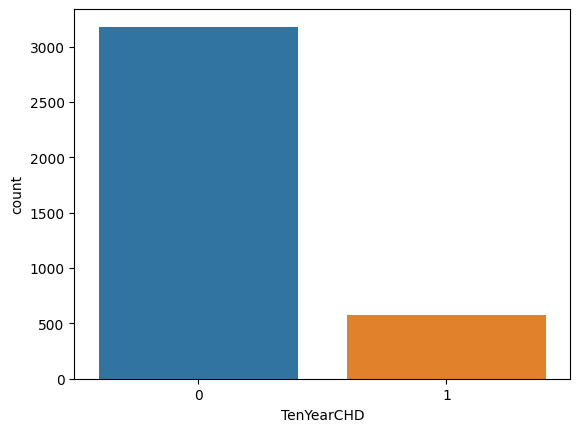

In [ ]:
# Count the number of rows for each category in the 'TenYearCHD' column
heart_df.groupby('TenYearCHD').count().show()

# Visualize the count of each category in the 'TenYearCHD' column
sn.countplot(x='TenYearCHD',data=heart_df.toPandas())

# Show summary statistics of the data
heart_df.describe().show()


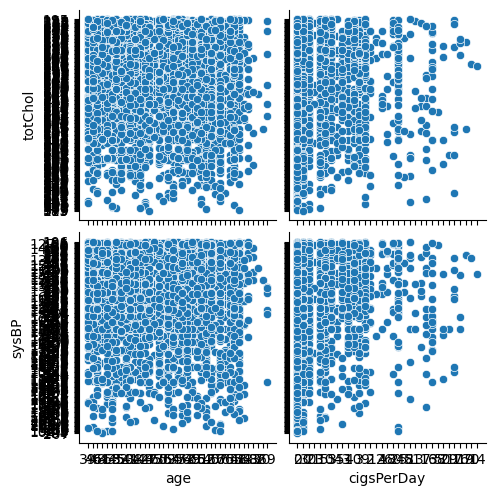

In [ ]:
# Convert PySpark DataFrame to pandas DataFrame
heart_df_pd = heart_df.toPandas()
# Visualize the pairwise relationships between features
sn.pairplot(data=heart_df_pd, x_vars=['age', 'cigsPerDay'], y_vars=['totChol', 'sysBP'])

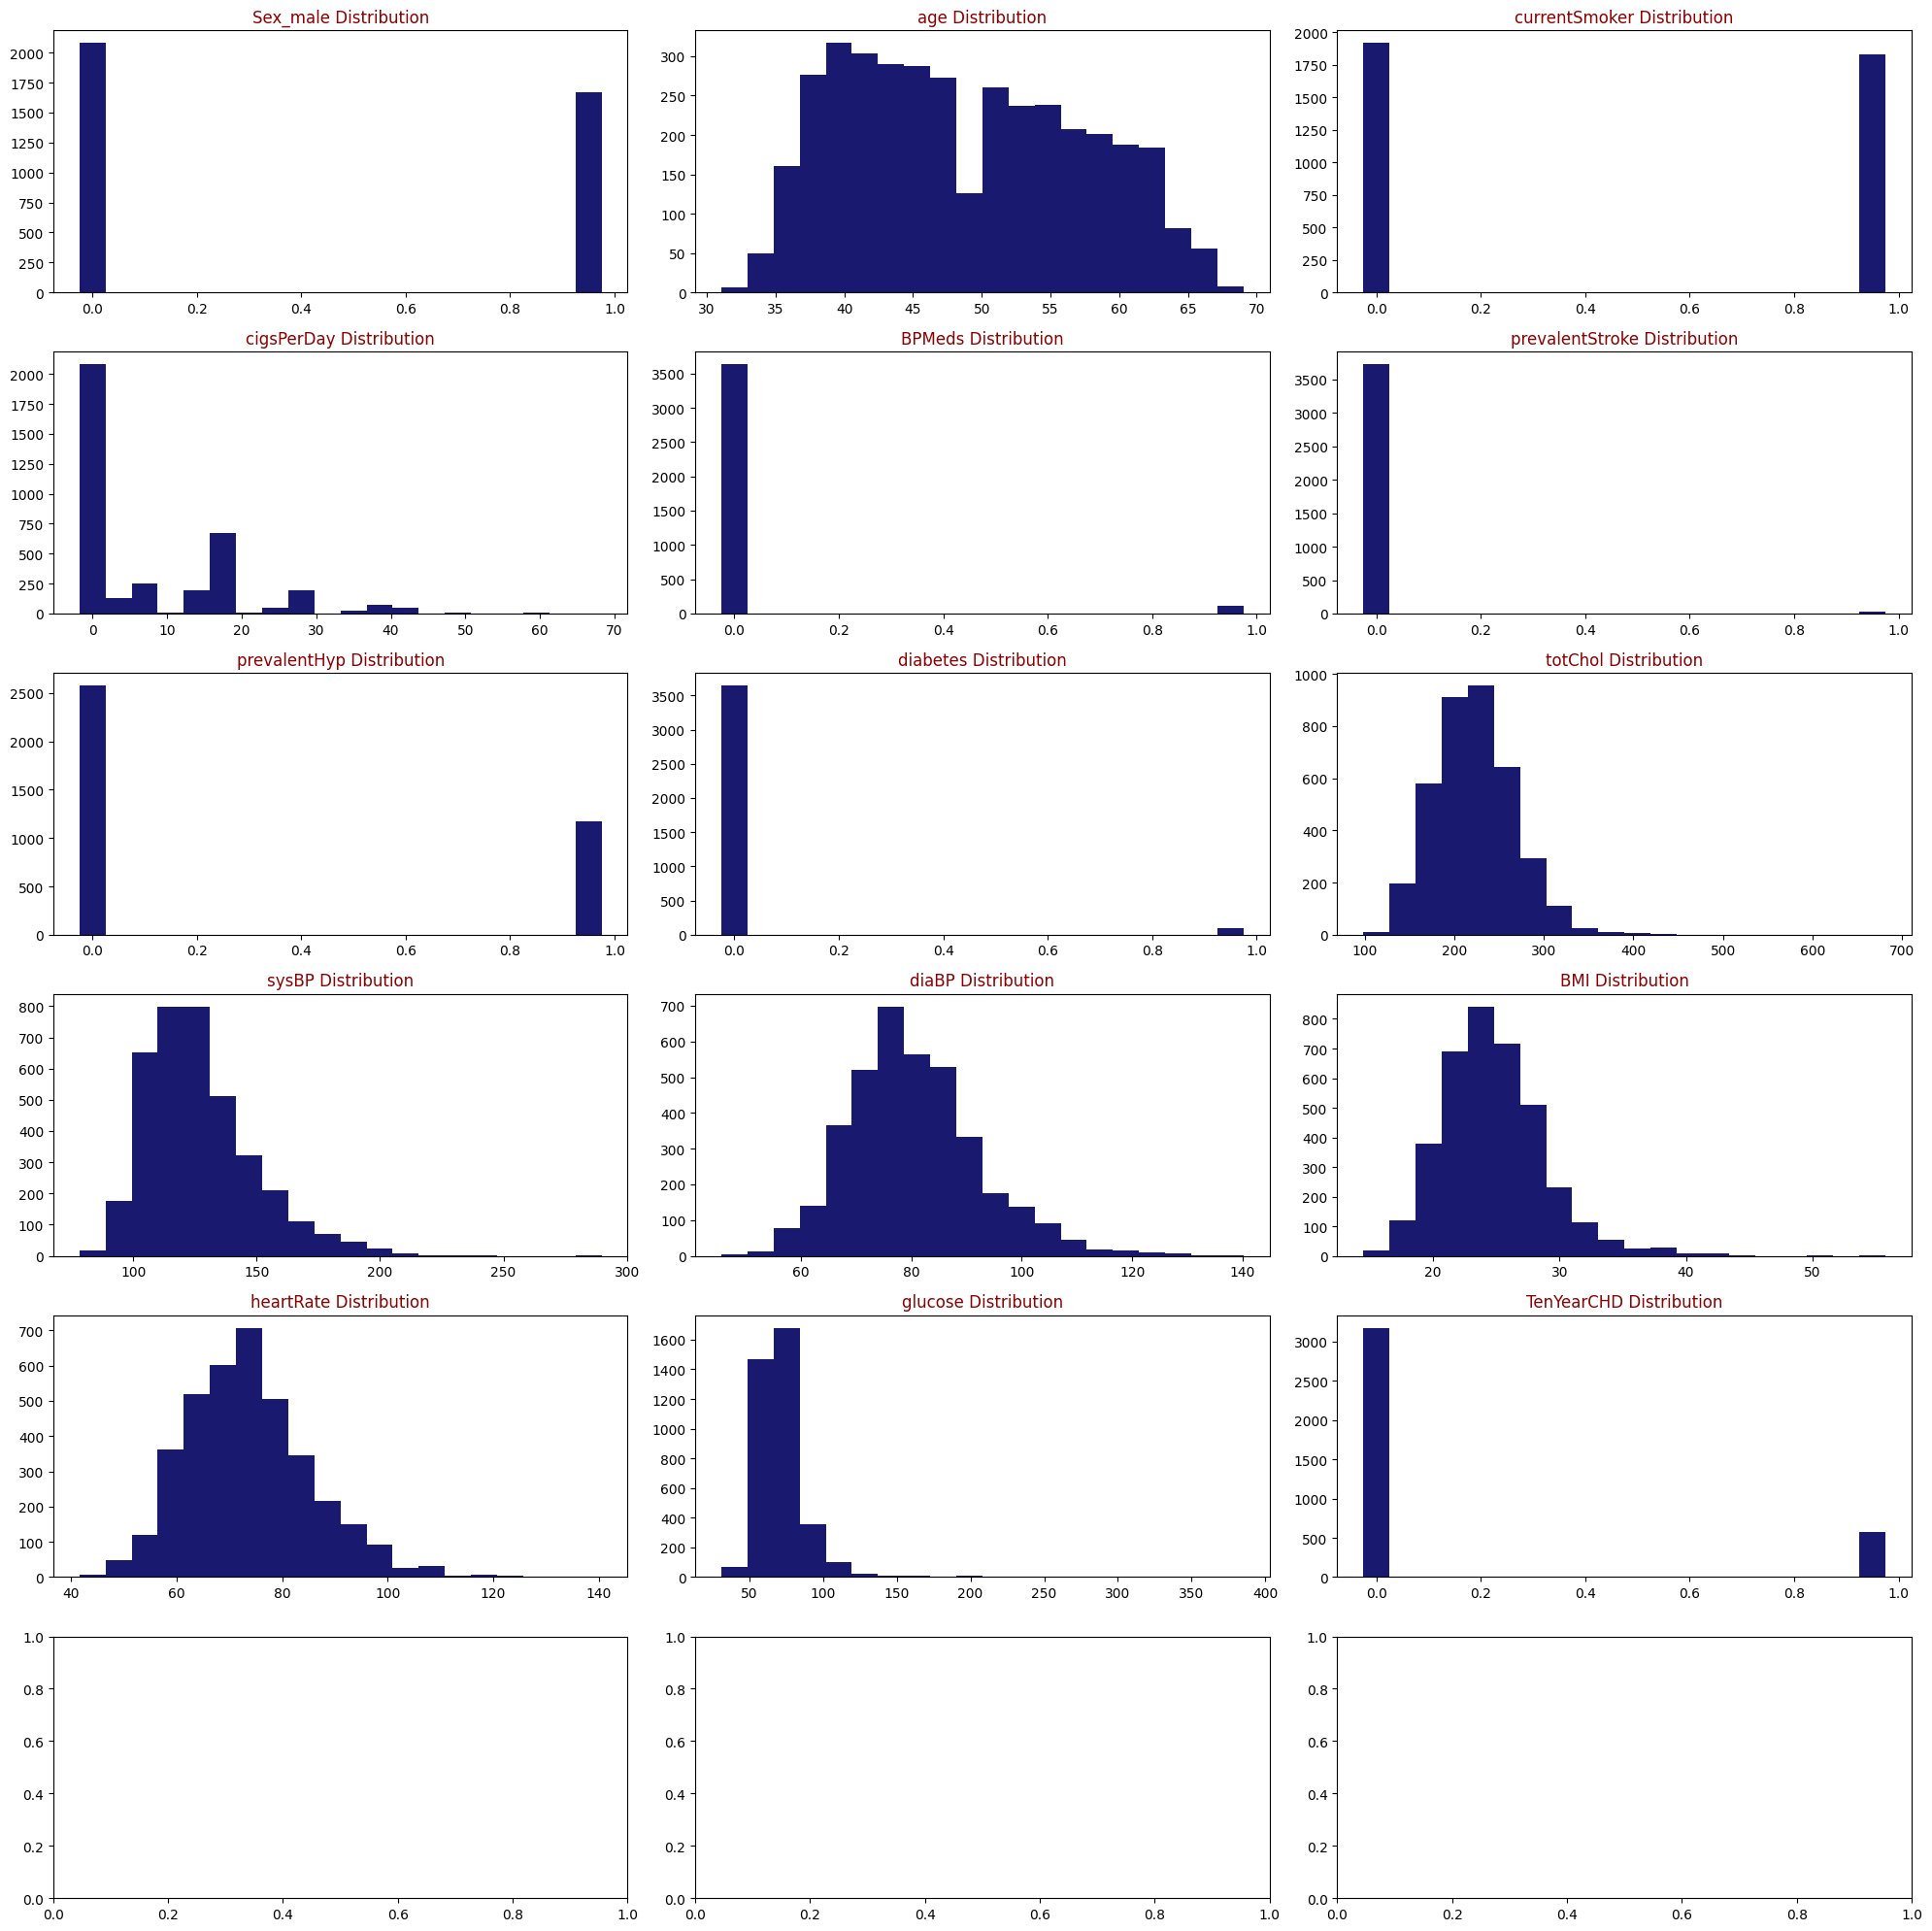

In [ ]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

def draw_histograms(dataframe, features, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20,20))
    axes = axes.ravel()

    for i, feature in enumerate(features):
        # Convert the column to a numerical type
        dataframe = dataframe.withColumn(feature, dataframe[feature].cast("double"))
        
        # Compute the histogram using PySpark functions
        bins, counts = dataframe.select(feature).rdd.flatMap(lambda x: x).histogram(20)
        
        # Plot the histogram using Matplotlib
        axes[i].bar(bins[:-1], counts, width=(bins[1]-bins[0]), color='midnightblue')
        axes[i].set_title(feature + " Distribution", color='DarkRed')

    fig.tight_layout()
    plt.show()

draw_histograms(heart_df, heart_df.columns, 6, 3)


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler


# Convert columns to appropriate data types
heart_df = heart_df.withColumn("Sex_male", heart_df["Sex_male"].cast("integer"))
heart_df = heart_df.withColumn("age", heart_df["age"].cast("integer"))
heart_df = heart_df.withColumn("currentSmoker", heart_df["currentSmoker"].cast("integer"))
heart_df = heart_df.withColumn("cigsPerDay", heart_df["cigsPerDay"].cast("integer"))
heart_df = heart_df.withColumn("BPMeds", heart_df["BPMeds"].cast("integer"))
heart_df = heart_df.withColumn("prevalentStroke", heart_df["prevalentStroke"].cast("integer"))
heart_df = heart_df.withColumn("prevalentHyp", heart_df["prevalentHyp"].cast("integer"))
heart_df = heart_df.withColumn("diabetes", heart_df["diabetes"].cast("integer"))
heart_df = heart_df.withColumn("totChol", heart_df["totChol"].cast("double"))
heart_df = heart_df.withColumn("sysBP", heart_df["sysBP"].cast("double"))
heart_df = heart_df.withColumn("diaBP", heart_df["diaBP"].cast("double"))
heart_df = heart_df.withColumn("BMI", heart_df["BMI"].cast("double"))
heart_df = heart_df.withColumn("heartRate", heart_df["heartRate"].cast("integer"))
heart_df = heart_df.withColumn("glucose", heart_df["glucose"].cast("double"))
heart_df = heart_df.withColumn("TenYearCHD", heart_df["TenYearCHD"].cast("integer"))

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler

# Create a vector assembler to assemble the features into a single vector column
assembler = VectorAssembler(inputCols=['Sex_male', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose'], outputCol='features')

# Use the assembler to transform the DataFrame and select the features and target columns
heart_df_assembled = assembler.transform(heart_df).select('features', 'TenYearCHD')

# Split the data into training and test sets
train_df, test_df = heart_df_assembled.randomSplit([0.8, 0.2], seed=42)

# Create a logistic regression model and fit it to the training data
lr = LogisticRegression(featuresCol='features', labelCol='TenYearCHD')
lr_model = lr.fit(train_df)

# Make predictions on the test data and evaluate the model's performance
predictions = lr_model.transform(test_df)
predictions.select('TenYearCHD', 'prediction', 'probability').show()

# Print the model's summary
print(lr_model.summary)


+----------+----------+--------------------+
|TenYearCHD|prediction|         probability|
+----------+----------+--------------------+
|         0|       0.0|[0.94363329040801...|
|         0|       0.0|[0.95855316722736...|
|         0|       0.0|[0.95545405582786...|
|         0|       0.0|[0.96355827665200...|
|         0|       0.0|[0.94156103004190...|
|         0|       0.0|[0.95540964309267...|
|         1|       0.0|[0.95155935116981...|
|         0|       0.0|[0.95090919982260...|
|         0|       0.0|[0.94299282789720...|
|         0|       0.0|[0.94965491640196...|
|         0|       0.0|[0.95142807636023...|
|         0|       0.0|[0.92511039935331...|
|         0|       0.0|[0.92801190789927...|
|         0|       0.0|[0.95767547816442...|
|         0|       0.0|[0.95524606554693...|
|         0|       0.0|[0.94782461920866...|
|         0|       0.0|[0.94595302829706...|
|         0|       0.0|[0.92896598545522...|
|         0|       0.0|[0.94820201743228...|
|         

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler



# Create a vector assembler to assemble the features into a single vector column
assembler = VectorAssembler(inputCols=['Sex_male', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose'], outputCol='features')

# Use the assembler to transform the DataFrame and select the features and target columns
heart_df_assembled = assembler.transform(heart_df).select('features', 'TenYearCHD')

# Split the data into training and test sets
train_df, test_df = heart_df_assembled.randomSplit([0.8, 0.2], seed=42)

# Create a logistic regression model and fit it to the training data
lr = LogisticRegression(featuresCol='features', labelCol='TenYearCHD')
lr_model = lr.fit(train_df)

# Make predictions on the test data and evaluate the model's performance
predictions = lr_model.transform(test_df)
predictions.select('TenYearCHD', 'prediction', 'probability').show()

# Print the model's summary
print(lr_model.summary)


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Make predictions on the test data and evaluate the model's performance
predictions = lr_model.transform(test_df)

# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='TenYearCHD', rawPredictionCol='rawPrediction')
accuracy = evaluator.evaluate(predictions)

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.7561616161616159
